In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from strat import getData

In [2]:
def perf_stats(data, grouped = False):
    cum_ret = lambda x: np.prod(x+1) - 1
    cum_ts = lambda x: (x+1).cumprod()
    ann_ret = lambda x: (np.prod(x+1))**(250/len(x)) - 1
    ann_vol = lambda x: np.std(x)*np.sqrt(250)
    ann_sr = lambda x, rf=0: (ann_ret(x)-rf)/ann_vol(x)
    mdd_ts = lambda x: cum_ts(x)/cum_ts(x).cummax()-1
    mdd = lambda x: -mdd_ts(x).min()
    d_std = lambda x: np.std(x[x<0])*np.sqrt(250)
    ann_cr = lambda x: ann_ret(x)/mdd(x) if mdd(x) != 0 else 0
    ann_sor = lambda x, ben = 0: (ann_ret(x)-ben)/d_std(x)
    func_ls = [cum_ret, ann_ret, ann_vol, mdd, ann_sr, ann_cr, ann_sor]
    stats_name = ["cumulative return", "annual return", "annual volatility", "maximum drawdown", "Sharpe ratio", "Calmar ratio", "Sortino ratio"]
    if not grouped:
        data = data.groupby(np.ones(len(data)))
    all_stats = []
    for name, group in data:
        stats = [func(group) for func in func_ls]
        if name == 1.0:
            name = "Total"
        all_stats.append(pd.Series(stats, index = stats_name, name = str(name)))
    return pd.concat(all_stats, axis = 1)

In [3]:
# 绘制图形
def one_curve_plot(pnl, figtitle):
    """remember to remove nan values"""
    
    # calculate time series
    cumulative = (pnl + 1).cumprod()
    max_return = cumulative.cummax()
    drawdown = (cumulative - max_return) / max_return
    
    # calculate performance statistics
    stats_total = perf_stats(pnl)
    pnl_yearly = pnl.groupby(pnl.index.year)
    stats_yearly = perf_stats(pnl_yearly, True)
    perf_stats_ = pd.concat([stats_total, stats_yearly], axis = 1).T.reset_index()
    cols_names = ["", "cumulative return", "annual return", "annual volatility", "maximum drawdown", "Sharpe ratio", "Calmar ratio", "Sortino ratio"]
    perf_stats_.update(perf_stats_[cols_names[1:]].applymap('{:,.4f}'.format))
    
    import matplotlib.pyplot as plt
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
    import matplotlib.ticker as ticker # 导入设置坐标轴的模块
#     plt.style.use('seaborn') # plt.style.use('dark_background')
    fig, (ax0, ax1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[1.2, 4]}, figsize=(16,10))

    # plot table
    ax0.set_axis_off() # 除去坐标轴
    cols_names = ["", "Cum. Return", "Ann. Return", "Ann. Vol", "Max Drawdown", "Sharpe", "Calmar", "Sortino"]
    table = ax0.table(cellText = perf_stats_.values,
                    bbox=(0,0,1,1), # 设置表格位置， (x0, y0, width, height)
                    rowLoc = 'center', # 行标题居中
                    cellLoc='center' ,
                    colLabels = cols_names, # 设置列标题
                     edges = 'open', # 不显示表格边框
                    colLoc = 'center' # 列标题居中
                    )
    table.set_fontsize(14)

    # 绘制累计收益曲线
    ax2 = ax1.twinx()
    ax1.yaxis.set_ticks_position('right') # 将回撤曲线的 y 轴移至右侧
    ax2.yaxis.set_ticks_position('left') # 将累计收益曲线的 y 轴移至左侧
    # 绘制回撤曲线
    drawdown.plot.area(ax=ax1, label='drawdown (right)', alpha=0.3, fontsize=13, grid=False)
    # 绘制累计收益曲线
    (cumulative).plot(ax=ax2, color='#F1C40F' , lw=3.0, label='cumret (left)', fontsize=13)
    # 不然 x 轴留有空白
    ax2.set_xbound(lower=cumulative.index.min(), upper=cumulative.index.max())
    # 主轴定位器：
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(365))
    # 同时绘制双轴的图例
    h1,l1 = ax1.get_legend_handles_labels()
    h2,l2 = ax2.get_legend_handles_labels()
    plt.legend(h1+h2,l1+l2, fontsize=14, loc='upper right', ncol=1)

    fig.suptitle(figtitle, fontsize = 14)
    fig.tight_layout(rect = [0, 0.02, 1, 0.98])
    plt.show()

In [4]:
def multi_curve_plot(pnl):
    # calculate time series
    cumulative = (pnl + 1).cumprod()
    max_return = cumulative.cummax()
    drawdown = (cumulative - max_return) / max_return
    
    # calculate performance statistics
    ls = []
    for i in range(len(pnl.columns)):
        ls.append(perf_stats(pnl.iloc[:,i]))
    perf_stats_ = pd.concat(ls, axis = 1).T
    perf_stats_.index = pnl.columns
    perf_stats_ = perf_stats_.reset_index()
    cols_names = ["", "cumulative return", "annual return", "annual volatility", "maximum drawdown", "Sharpe ratio", "Calmar ratio", "Sortino ratio"]
    perf_stats_.update(perf_stats_[cols_names[1:]].applymap('{:,.4f}'.format))
    
    import matplotlib.pyplot as plt
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
    import matplotlib.ticker as ticker # 导入设置坐标轴的模块
    plt.style.use('seaborn') # plt.style.use('dark_background')
    n = len(cumulative.columns)
    fig, (ax0, ax1 ,ax2) = plt.subplots(3,1, gridspec_kw = {'height_ratios':[1*n, 8, 8]}, figsize=(15,12))

    # plot table
    ax0.set_axis_off() # 除去坐标轴
    cols_names = ["", "Cum. Return", "Ann. Return", "Ann. Vol", "Max Drawdown", "Sharpe", "Calmar", "Sortino"]
    table = ax0.table(cellText = perf_stats_.values,
                    bbox=(0,0,1,1), # 设置表格位置， (x0, y0, width, height)
                    rowLoc = 'center', # 行标题居中
                    cellLoc='center' ,
                    colLabels = cols_names, # 设置列标题
                    colLoc = 'center', # 列标题居中
                    edges = 'open' # 不显示表格边框
                    )
    table.set_fontsize(14)

    # drawdown plot
    drawdown.plot.area(ax=ax1, label='drawdown (right)', stacked = False, rot=0, alpha=0.3, fontsize=13)
    # cumulative plot
    cumulative.plot(ax=ax2, rot=0, fontsize=13)
    # bar plot 
#     exog = exog[data.index]
#     ax3 = ax2.twinx()
#     exog.plot.bar(ax=ax3, rot=0)
    
    ax1.set_xbound(lower=drawdown.index.min(), upper=drawdown.index.max())
    ax2.set_xbound(lower=cumulative.index.min(), upper=cumulative.index.max())
    # 主轴定位器：
#     ax3.xaxis.set_major_locator(ticker.MultipleLocator(60))
    
    fig.tight_layout() # 规整排版
    plt.show()



In [5]:
from strat import getData
hsi_price = getData("1001098", add_rsq = True)
hsi = hsi_price.close.pct_change()

C:\Users\arizonazhang\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


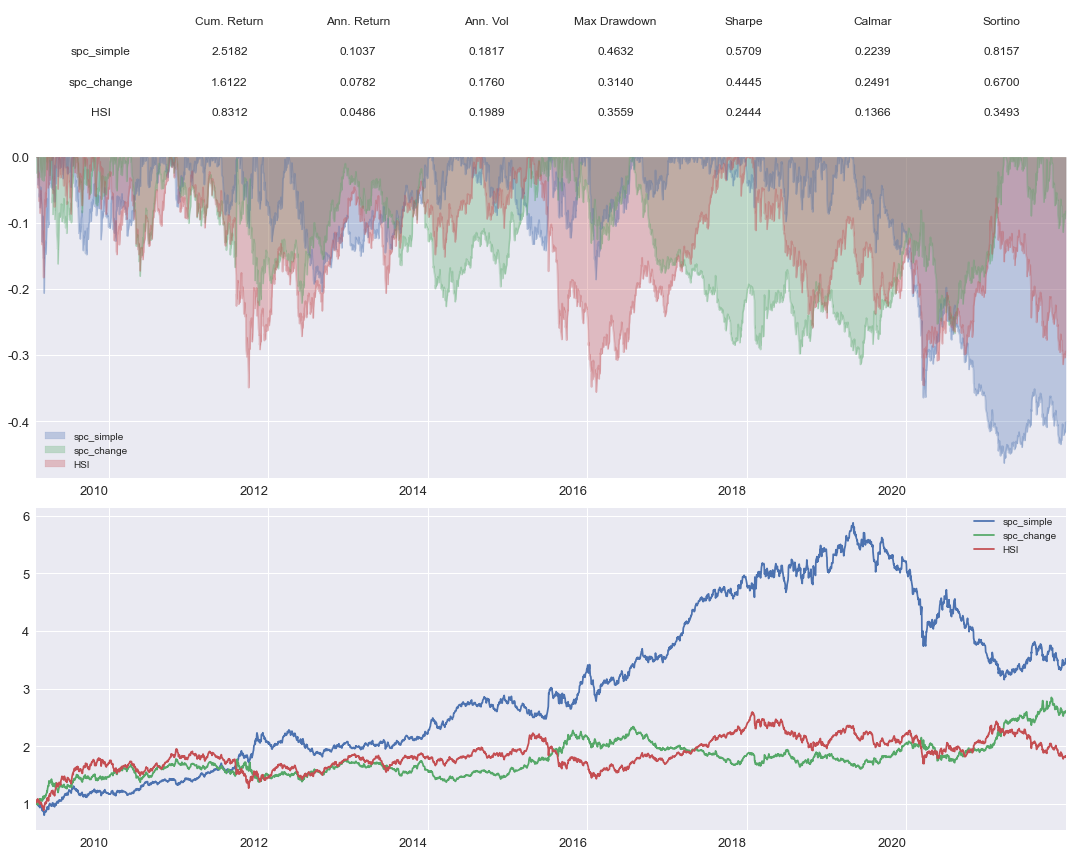

In [6]:
data1 = pd.read_csv("pnl_Strat_Simple.csv", index_col=0)
data1.index = pd.to_datetime(data1.index)

data2 = pd.read_csv("pnl_Strat_Change.csv", index_col=0)
data2.index = pd.to_datetime(data2.index)

data = data1.join(data2, rsuffix=" ")
data = data.join(hsi)
data.columns = ['spc_simple', 'spc_change', 'HSI']

multi_curve_plot(data.iloc[20:])

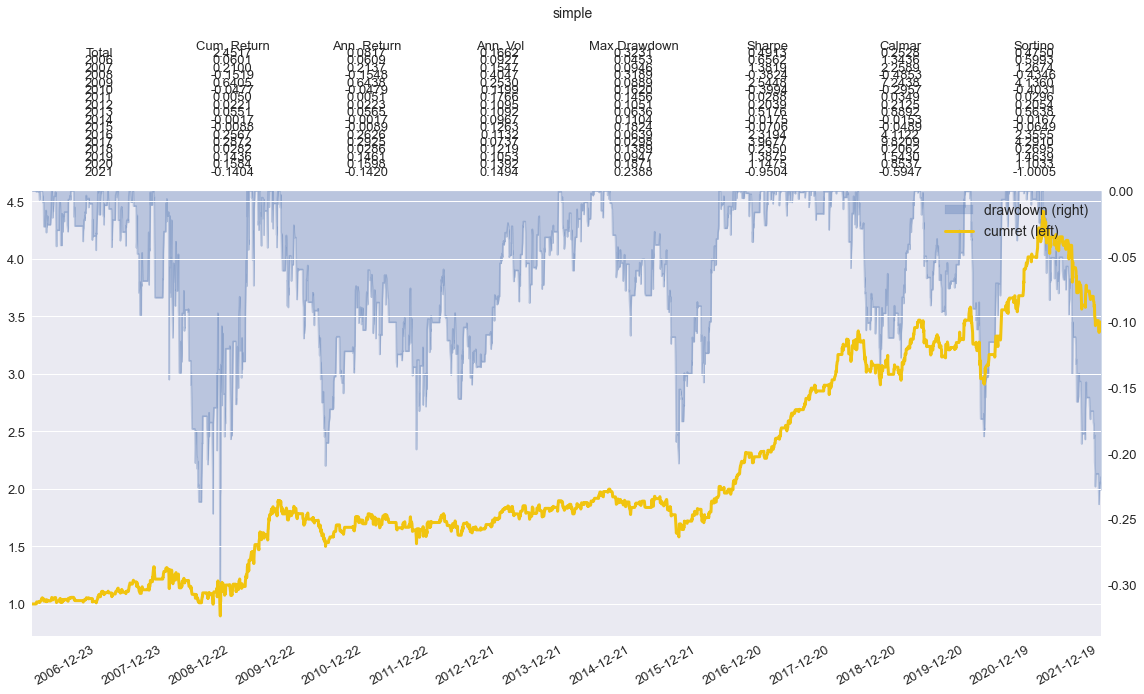

In [20]:
data1 = pd.read_csv("pnl_Strat_WChange_182.csv", index_col=0)
data1.index = pd.to_datetime(data1.index)
one_curve_plot(data1["0"], figtitle="simple")

In [ ]:
data1 = pd.read_csv("pnl_Strat_Change.csv", index_col=0)
data1.index = pd.to_datetime(data1.index)
one_curve_plot(data1["0"], figtitle="simple")

In [ ]:
data = data1.join(data2, rsuffix=" ")
data.columns = ['spc_long_short', 'spc_reverse']

multi_curve_plot(data)

### Comparing Maturity of 1y and 6 months

In [14]:
def compare2(paths, names):
    ls = []
    for path in paths:
        data = pd.read_csv(path, index_col=0)
        data.index = pd.to_datetime(data.index)
        ls.append(data)
    df = pd.concat(ls, axis=1)
    df = df.join(hsi)
    df.columns = names + ['HSI']
    multi_curve_plot(df[df.index.year>=2006])
    return df

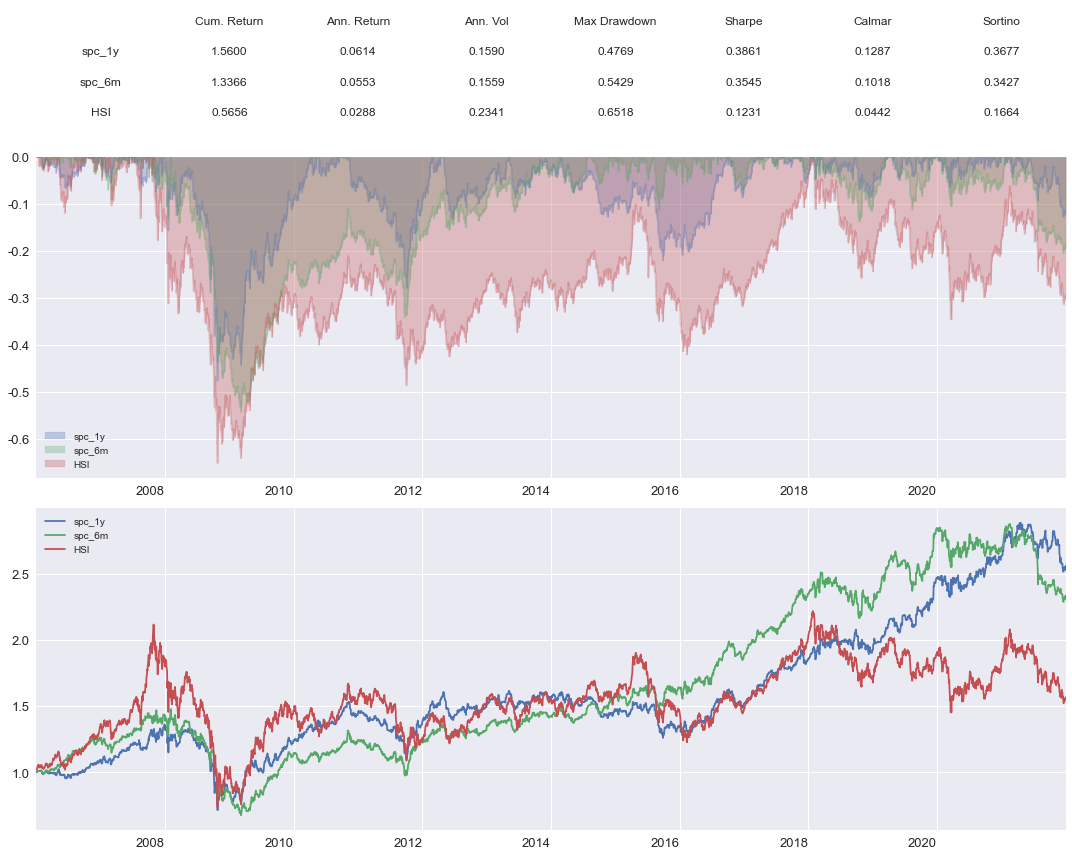

In [8]:
compare2(["pnl_Strat_Change_365.csv", "pnl_Strat_Change_182.csv"], 
        ['spc_1y', 'spc_6m'])

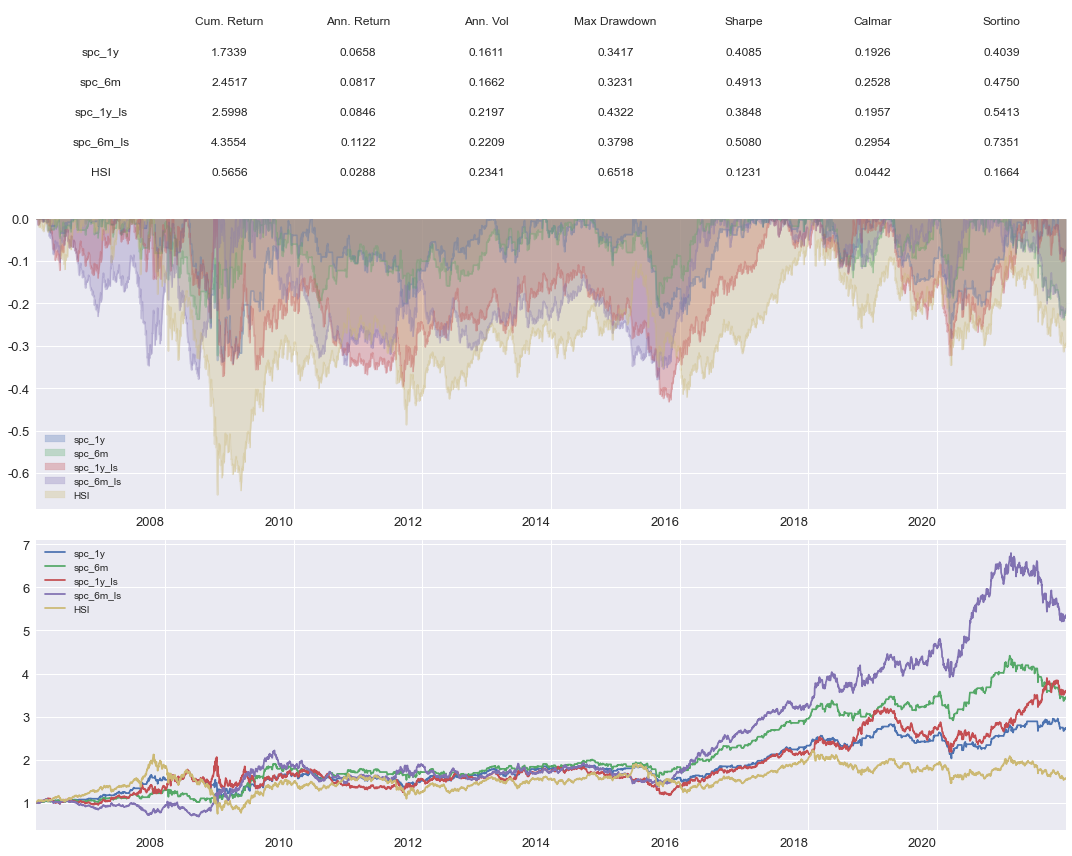

In [7]:
compare2(["pnl_Strat_WChange_365.csv", "pnl_Strat_WChange_182.csv", "pnl_Strat_WChangeLS_365.csv", "pnl_Strat_WChangeLS_182.csv"], 
        ['spc_1y', 'spc_6m', 'spc_1y_ls', 'spc_6m_ls'])

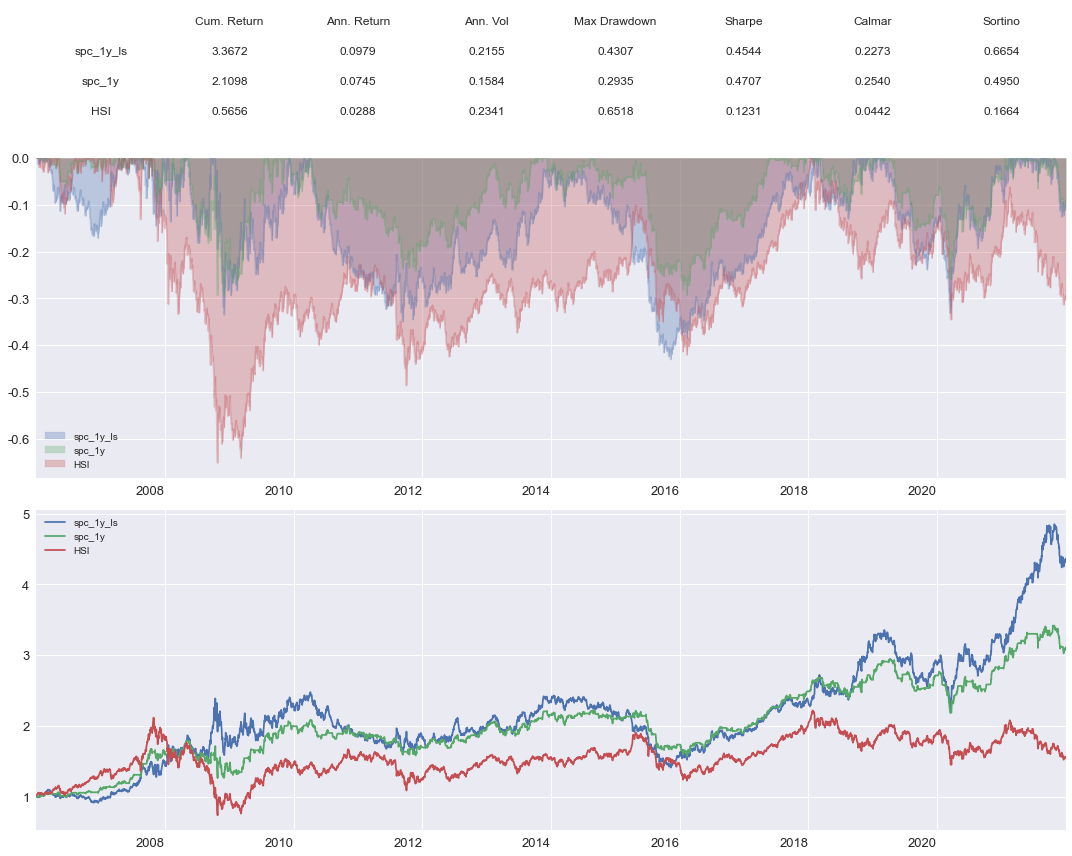

In [13]:
compare2(["pnl_wchange_ls_365.csv", "pnl_wchange_365.csv"], 
        ['spc_1y_ls', 'spc_1y'])

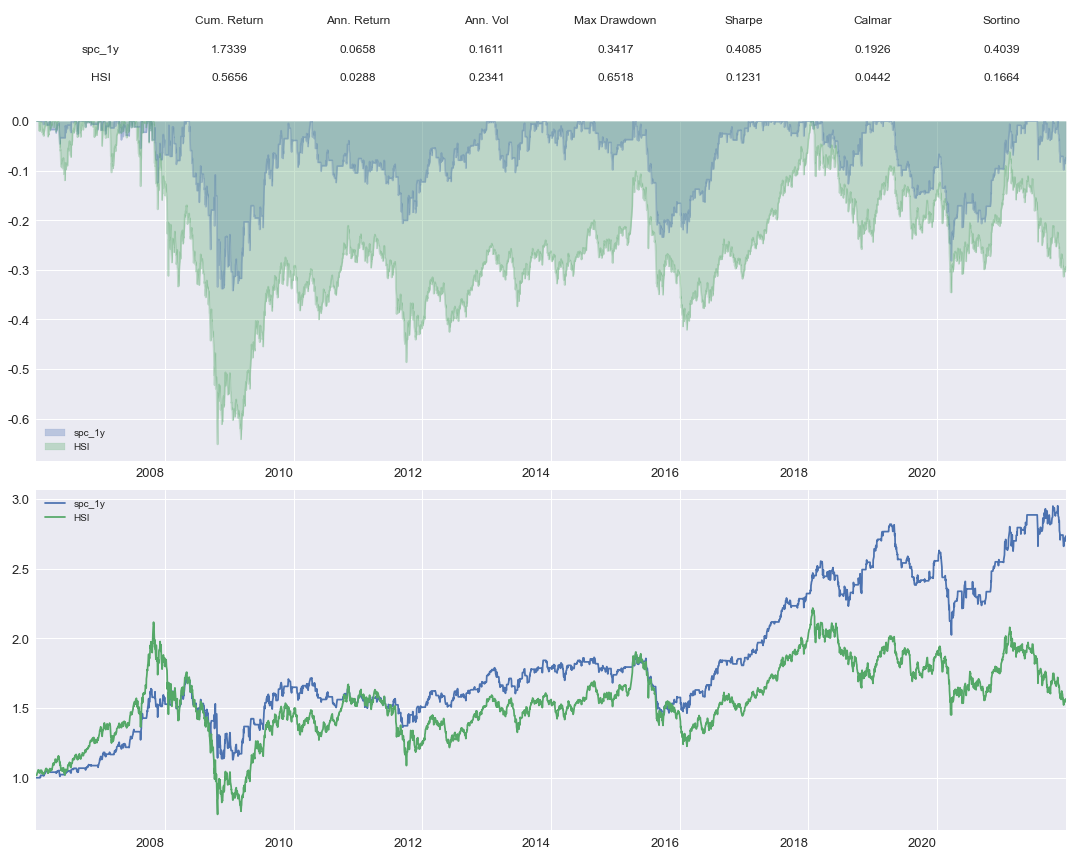

In [24]:
df = compare2([ "pnl_wchange_365.csv"], ['spc_1y'])

### Compare Different Lag

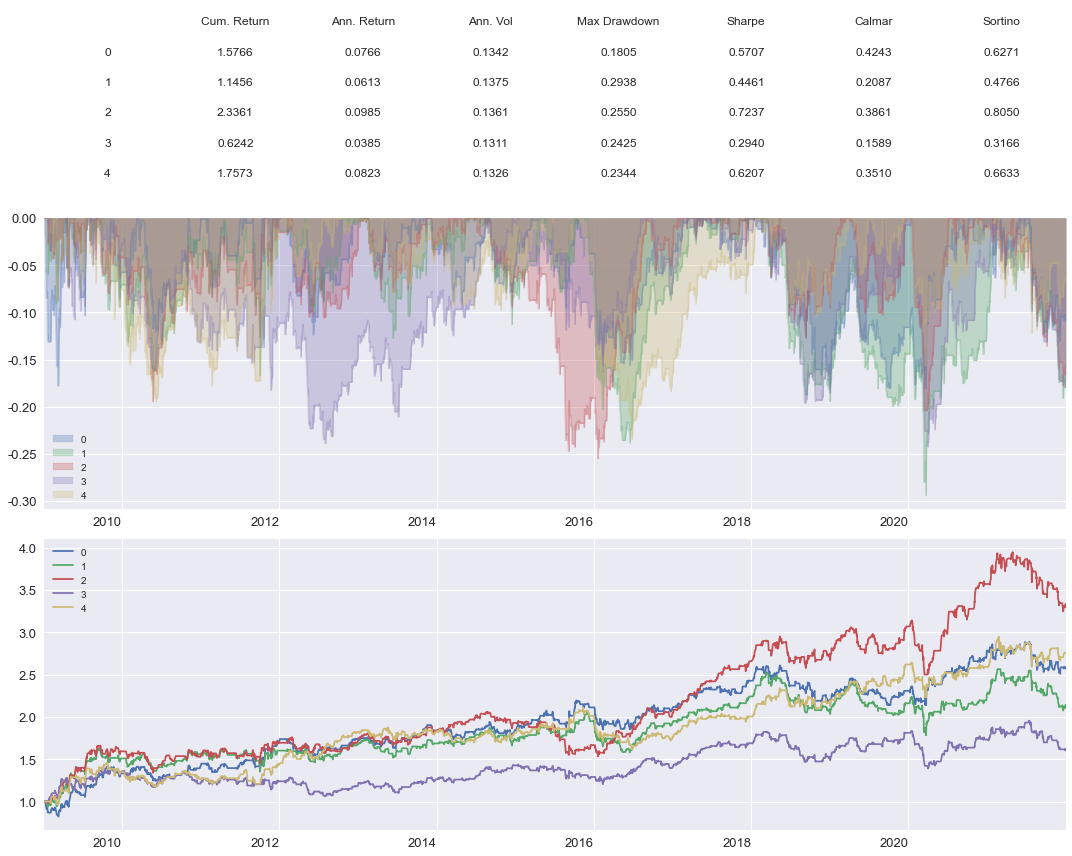

In [25]:
data1 = pd.read_csv("pnls_Strat_WChange_182.csv", index_col=0)
data1.index = pd.to_datetime(data1.index)
multi_curve_plot(data1)

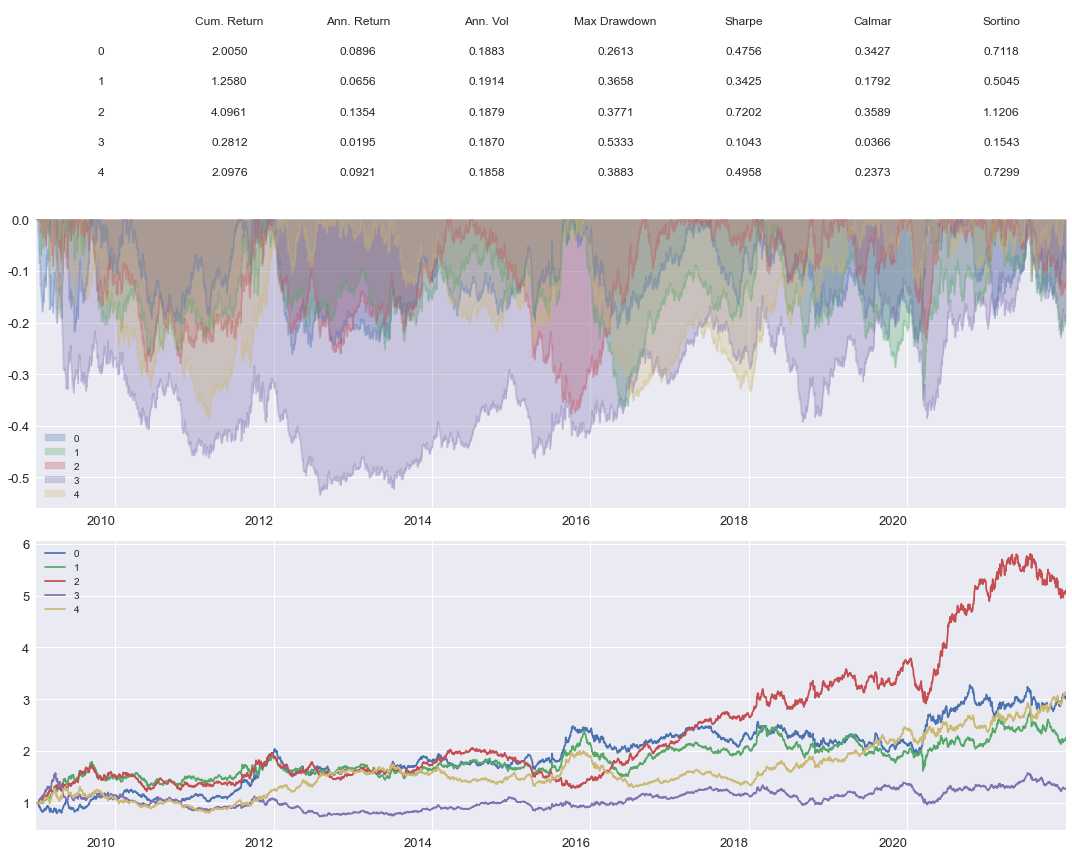

In [24]:
data1 = pd.read_csv("pnls_Strat_WChangeLS_182.csv", index_col=0)
data1.index = pd.to_datetime(data1.index)
multi_curve_plot(data1)

In [ ]:
print("threshold {:.2f}".format(1.96/len(hsi_price.spc)**0.5))
lag = 100
ls = [hsi_price.spc.autocorr(i) for i in range(1, lag)]
ls_ci = [1.96/len(hsi_price.spc)**0.5 for i in range(1, lag)]
pd.Series(ls).plot.bar(figsize=(15,3))
pd.Series(ls_ci).plot(style='-', color="tab:gray")

In [ ]:
hsi_price.spc.iloc[520:].plot(figsize=(20,5))
# hsi_price.spc.iloc[520:].rolling(window=20).std().plot(figsize=(20,5), label="std")
hsi_price.spc.iloc[520:].rolling(window=20).mean().plot(figsize=(20,5), label="mean")

In [ ]:
pnls = pd.read_csv('pnls.csv', index_col=0)
multi_curve_plot(pnls.iloc[:,10:])